# MCMC for Linear regression with normal distribution

<!-- ![gamblimg machine](https://image.made-in-china.com/44f3j00IumtHGLCabcD/American-Original-Touch-Screen-Casino-Games-Cabinets-Slot-Gambling-Machine.jpg) -->
<center>
 <img src="https://image.made-in-china.com/44f3j00IumtHGLCabcD/American-Original-Touch-Screen-Casino-Games-Cabinets-Slot-Gambling-Machine.jpg" alt="Girl in a jacket" width="80%"> </center>


In [5]:
# import libraries
import jax
import jax.numpy as jnp
try:
  import distrax
except:
  %pip install -qq distrax
  import distrax
import tensorflow as tf
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
try:
    import blackjax
except:
    %pip install -qq blackjax
    import blackjax
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
import logging
import pickle
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
key = jax.random.PRNGKey(5)


In [6]:
with open("../data/linear regression normal distribution",'rb') as f:
    data = pickle.load(f)

In [7]:
data

{'data': {'x': array([[-1.4144772 ],
         [ 1.6039085 ],
         [ 2.293806  ],
         [ 3.8276772 ],
         [ 1.999692  ],
         [ 1.0609426 ],
         [ 1.2900534 ],
         [-2.3558607 ],
         [ 3.0193057 ],
         [-0.89879274]], dtype=float32),
  'y': array([ 1.2143412,  7.422146 , 10.44427  , 12.321105 ,  7.133485 ,
          6.848776 ,  6.8407617, -1.5791223, 11.820506 ,  1.6998756],
        dtype=float32)},
 'noise_variance': 1,
 'prior': {'mean': array([14. ,  7.3], dtype=float32),
  'var': array([[10.,  0.],
         [ 0., 10.]], dtype=float32)}}

In [8]:
x = jnp.array(data['data']['x'])
def identity_trans(x):
    return jnp.append(jnp.ones((m,1)),x,axis=1)
m = x.shape[0]
x_trans = identity_trans(x)
y = jnp.array(data['data']['y'])
prior_mean = jnp.array(data['prior']['mean'])
prior_var = jnp.array(data['prior']['var'])
noise_var = data['noise_variance']

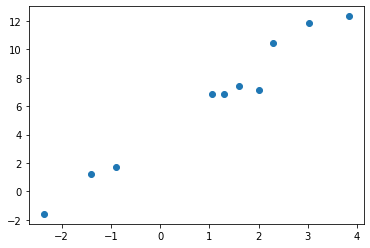

In [9]:
plt.scatter(x,y)


In [10]:
n = x_trans.shape[1]
prior_normal = tfd.MultivariateNormalFullCovariance(
    loc = prior_mean,covariance_matrix= prior_var
)
print(prior_normal.prob([2.1,2.2]))

3.6475258e-06


In [19]:
y = y.reshape(m,)
def log_postfn(theta):
  # from the above equation
  log_prior = prior_normal.log_prob(theta)
  # log_likelihood
  mean = (x_trans@theta.reshape(n,1)).reshape(m,)
  likelihood_student = tfd.Laplace(mean,1)
  log_like = jnp.array(jnp.sum(likelihood_student.log_prob(y)))
  return (log_like+log_prior)
log_postfn(jnp.array([10.4,11.4]))

DeviceArray(-217.97997, dtype=float32)

In [20]:
rmh = blackjax.rmh(log_postfn, sigma=jnp.identity(n) * 0.7)
initial = jnp.array(jnp.array([10.4,11.4]))
initial_state = rmh.init(initial)
initial_state

RMHState(position=DeviceArray([10.4, 11.4], dtype=float32), log_probability=DeviceArray(-217.97997, dtype=float32))

In [21]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [22]:
rng_key = jax.random.PRNGKey(0)
_, rng_key = jax.random.split(rng_key)
states = inference_loop(rng_key, rmh.step, initial_state, 10000)

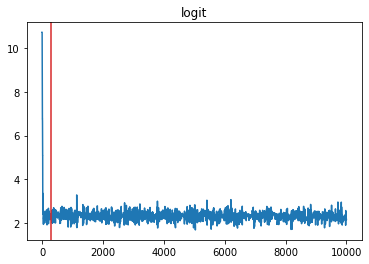

In [23]:
burnin = 300
fig, ax = plt.subplots()
ax.plot(states.position[:,1])
ax.set_title(f"logit")
ax.axvline(x=burnin, c="tab:red")
plt.show()